A cute little demo showing the simplest usage of minGPT. Configured to run fine on Macbook Air in like a minute.

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)

In [2]:
import pickle

class SortDataset(Dataset):
    """ 
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.num_digits
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):
        
        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that 
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y


## Add

In [3]:
import random

def random_add_instance(length):
    a = [random.randint(0,9) for i in range(length)]
    b = [random.randint(0,9) for i in range(length)]
    val_a = int(''.join(str(d) for d in a))
    val_b = int(''.join(str(d) for d in b))
    val_c = val_a + val_b
    str_c = str(val_c)
    str_c = (length + 1 - len(str_c)) * '0' + str_c
    return a + b + [int(d) for d in str_c]

for i in range(10):
    print (random_add_instance(3))



[0, 6, 2, 5, 3, 6, 0, 5, 9, 8]
[4, 9, 5, 3, 7, 8, 0, 8, 7, 3]
[6, 4, 4, 3, 1, 4, 0, 9, 5, 8]
[3, 5, 9, 1, 1, 9, 0, 4, 7, 8]
[3, 5, 0, 1, 4, 8, 0, 4, 9, 8]
[0, 0, 2, 9, 3, 7, 0, 9, 3, 9]
[8, 4, 8, 2, 3, 7, 1, 0, 8, 5]
[9, 9, 9, 7, 0, 6, 1, 7, 0, 5]
[7, 4, 5, 1, 3, 6, 0, 8, 8, 1]
[1, 0, 1, 0, 4, 2, 0, 1, 4, 3]


In [3]:
class AddDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return 10
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 3 * self.length + 1 - 1

    def __getitem__(self, idx):
        while True:
            rai = random_add_instance(self.length)
            h = hash(str(rai[:2*self.length]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*self.length-1] = -1
        return x, y

In [4]:
# print an example instance of the dataset
train_dataset = AddDataset('train')
test_dataset = AddDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([2, 9, 3, 4, 8, 0, 0, 7, 7])
2 -1
9 -1
3 -1
4 -1
8 -1
0 0
0 7
7 7
7 3


In [6]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-micro'
model_config.model_type = 'gpt-nano'

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.09M


In [7]:
print (model_config.n_head, model_config.n_layer, model_config.n_embd)

3 3 48


In [12]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


In [13]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 1.32937
iter_dt 15.88ms; iter 100: train loss 1.29775
iter_dt 16.49ms; iter 200: train loss 1.28916
iter_dt 16.57ms; iter 300: train loss 1.31216
iter_dt 16.32ms; iter 400: train loss 1.30274
iter_dt 16.49ms; iter 500: train loss 1.29706
iter_dt 16.15ms; iter 600: train loss 1.25459
iter_dt 16.70ms; iter 700: train loss 1.26540
iter_dt 15.13ms; iter 800: train loss 1.28608
iter_dt 13.34ms; iter 900: train loss 1.31439
iter_dt 13.39ms; iter 1000: train loss 1.29671
iter_dt 14.00ms; iter 1100: train loss 1.25890
iter_dt 13.92ms; iter 1200: train loss 1.24503
iter_dt 14.11ms; iter 1300: train loss 1.28746
iter_dt 10.05ms; iter 1400: train loss 1.23210
iter_dt 13.81ms; iter 1500: train loss 1.21414
iter_dt 10.42ms; iter 1600: train loss 1.24760
iter_dt 11.70ms; iter 1700: train loss 1.18891
iter_dt 11.09ms; iter 1800: train loss 1.15542
iter_dt 12.20ms; iter 1900: train loss 1.14518
iter_dt 12.98ms; iter 2000: train loss 1.02021
iter_dt 15.06ms; iter 2100

In [14]:
# now let's perform some evaluation
model.eval()
None

In [15]:
def eval_add_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    #loader = DataLoader(dataset, batch_size=1, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)

        inp = x[:, :2*n]
        sol = y[:, -n-1:]
        
        cat = model.generate(inp, n+1, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, -n-1:]         
        correct = (sol == sol_candidate).all(1).cpu() 
        for i in range(x.size(0)):
            results.append(int(correct[i]))
    
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_add_split(trainer, 'train', max_batches=50)
    test_score  = eval_add_split(trainer, 'test',  max_batches=50)

train final score: 9508/10000 = 95.08% correct
test final score: 9512/10000 = 95.12% correct


## Multiply

In [3]:
import random

def random_mul_instance(length):
    a = [random.randint(0,9) for i in range(length)]
    b = [random.randint(0,9) for i in range(length)]
    val_a = int(''.join(str(d) for d in a))
    val_b = int(''.join(str(d) for d in b))
    val_c = val_a * val_b
    str_c = str(val_c)
    str_c = (2*length - len(str_c)) * '0' + str_c
    return a + b + [int(d) for d in str_c]

for i in range(10):
    print (random_mul_instance(3))

[0, 6, 2, 5, 3, 6, 0, 3, 3, 2, 3, 2]
[4, 9, 5, 3, 7, 8, 1, 8, 7, 1, 1, 0]
[6, 4, 4, 3, 1, 4, 2, 0, 2, 2, 1, 6]
[3, 5, 9, 1, 1, 9, 0, 4, 2, 7, 2, 1]
[3, 5, 0, 1, 4, 8, 0, 5, 1, 8, 0, 0]
[0, 0, 2, 9, 3, 7, 0, 0, 1, 8, 7, 4]
[8, 4, 8, 2, 3, 7, 2, 0, 0, 9, 7, 6]
[9, 9, 9, 7, 0, 6, 7, 0, 5, 2, 9, 4]
[7, 4, 5, 1, 3, 6, 1, 0, 1, 3, 2, 0]
[1, 0, 1, 0, 4, 2, 0, 0, 4, 2, 4, 2]


In [45]:
class MulDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return 10
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 4 * self.length - 1

    def __getitem__(self, idx):
        while True:
            rai = random_mul_instance(self.length)
            h = hash(str(rai[:2*self.length]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*self.length-1] = -1
        return x, y

In [46]:
# print an example instance of the dataset
train_dataset = MulDataset('train')
test_dataset = MulDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([3, 1, 6, 9, 8, 0, 3, 0, 9, 6, 8])
3 -1
1 -1
6 -1
9 -1
8 -1
0 3
3 0
0 9
9 6
6 8
8 0


In [47]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-micro'
# model_config.model_type = 'gpt-nano'

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.80M


In [48]:
# model.load_state_dict(torch.load('model_4_42.pth'))

model.load_state_dict(torch.load('model_4_42.pth', map_location=torch.device('cpu')))

/tmp/ipykernel_242452/2190779374.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_4_42.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [9]:
print (model_config.n_head, model_config.n_layer, model_config.n_embd)

4 4 128


In [49]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
# train_config.batch_size = 32
trainer = Trainer(train_config, model, train_dataset)

running on device cpu


In [11]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.70033


KeyboardInterrupt: 

In [50]:
# now let's perform some evaluation
model.eval()
None

train final score: 434/10000 = 4.34% correct
test final score: 438/10000 = 4.38% correct


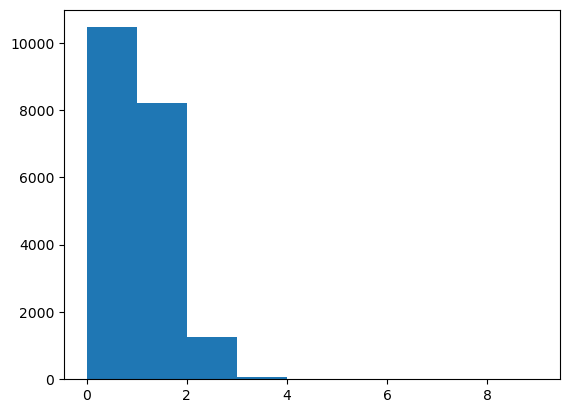

In [52]:
import matplotlib.pyplot as plt

errors = []

def eval_add_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    #loader = DataLoader(dataset, batch_size=1, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)

        inp = x[:, :2*n]
        sol = y[:, -2*n:]
        
        cat = model.generate(inp, 2*n, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, -2*n:]      
        # print(cat)
        # print(n)
        # print(sol)   
        # print(sol_candidate)
        correct = (sol == sol_candidate).all(1).cpu() 
        mae = torch.abs(sol - sol_candidate).abs().float().mean(1).cpu()
        errors.extend(mae.tolist())

        for i in range(x.size(0)):
            results.append(int(correct[i]))
    
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_add_split(trainer, 'train', max_batches=50)
    test_score  = eval_add_split(trainer, 'test',  max_batches=50)


plt.hist(errors, bins=range(10))
plt.show()



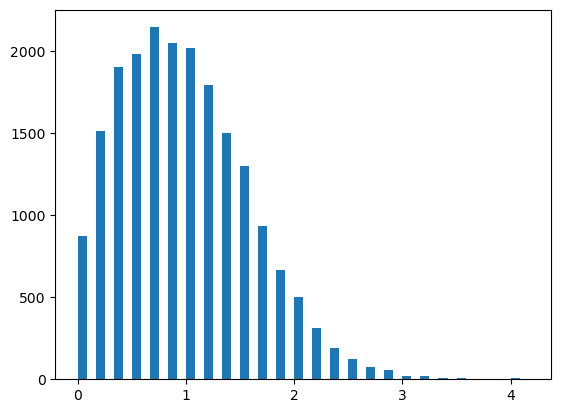

In [55]:
plt.hist(errors, bins=50)
plt.show()

In [92]:
torch.save(model.state_dict(), 'model_weights.pth')

## Binary multiplication

In [17]:
def random_bin_instance(length):
    a = [random.randint(0, 1) for _ in range(length)]
    b = [random.randint(0, 1) for _ in range(length)]
    val_a = int(''.join(str(d) for d in a), 2)
    val_b = int(''.join(str(d) for d in b), 2)
    val_c = val_a * val_b
    str_c = bin(val_c)[2:]
    str_c = (2 * length - len(str_c)) * '0' + str_c
    return a + b + [int(d) for d in str_c]

for i in range(10):
    print(random_bin_instance(10))

[1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
[1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]
[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]
[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
[1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0]
[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0

In [23]:
class BinDataset(Dataset):
    """ 
    Dataset for the binary multiplication problem. E.g. for problem length 3:
    101 * 110 = 11110
    Input: 1 0 1 1 1 0 -> Output: 0 1 1 1 1 0
    Which will feed into the transformer concatenated as:
    input:  1 0 1 1 1 0 0 1 1 1 1
    output: I I I I I I 0 1 1 1 1 0
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=10):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return 2
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 4 * self.length

    def __getitem__(self, idx):
        while True:
            rai = random_bin_instance(self.length)
            h = hash(str(rai[:2*self.length]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*self.length-1] = -1
        return x, y

# print an example instance of the dataset
train_dataset = BinDataset('train')
test_dataset = BinDataset('test')
x, y = train_dataset[0]

print(x)
for a, b in zip(x, y):
    print(int(a), int(b))

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0])
0 -1
0 -1
0 -1
0 -1
0 -1
0 -1
0 -1
1 -1
0 -1
0 -1
1 -1
0 -1
1 -1
1 -1
1 -1
1 -1
1 -1
1 -1
1 -1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
1 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 0
0 0
0 0


In [24]:
train_dataset = BinDataset('train')
test_dataset = BinDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))


tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0])
0 -1
1 -1
1 -1
0 -1
0 -1
0 -1
0 -1
1 -1
0 -1
0 -1
1 -1
1 -1
1 -1
0 -1
0 -1
1 -1
0 -1
0 -1
1 -1
0 0
0 1
1 0
0 1
1 0
0 1
1 1
1 0
0 1
1 0
0 0
0 1
1 0
0 1
1 0
0 0
0 1
1 0
0 0
0 0


In [29]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()
# model_config.model_type = 'gpt-micro'
model_config.model_type = 'gpt-nano'

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.09M


In [38]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-6 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
# train_config.batch_size = 32
trainer = Trainer(train_config, model, train_dataset)

running on device cpu


In [39]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.58357
iter_dt 71.87ms; iter 100: train loss 0.60101
iter_dt 66.51ms; iter 200: train loss 0.59639
iter_dt 76.73ms; iter 300: train loss 0.59338
iter_dt 76.73ms; iter 400: train loss 0.58720


KeyboardInterrupt: 

In [40]:
model.eval()
None

In [42]:
def evaluate_model(trainer, dataset, max_batches=50):
    model.eval()
    n = dataset.length
    results = []
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    
    for b, (x, y) in enumerate(loader):
        if b >= max_batches:
            break
        x = x.to(trainer.device)
        y = y.to(trainer.device)

        inp = x[:, :2*n]
        sol = y[:, -2*n:]
        
        with torch.no_grad():
            cat = model.generate(inp, 2*n, do_sample=False)
        
        sol_candidate = cat[:, -2*n:]
        correct = (sol == sol_candidate).all(1).cpu()
        results.extend(correct.tolist())

        if b >= max_batches:
            break
    
    accuracy = sum(results) / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Evaluate the model on the test dataset
evaluate_model(trainer, test_dataset)

Accuracy: 0.18%


0.0018